<a href="https://colab.research.google.com/github/ttya16/ArtificialNeuralNetwork/blob/master/ArtificialNeuralNetwork_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 人工ニューラルネット
##DNNの訓練 (part1の続き)



## Optimizerあれこれ
学習時間の短縮を考える際に、パラメータの更新方法も優れたものを選ぶ必要がある。
単純な勾配降下法よりも高速で性能の良い代表的なものを挙げていく。

In [0]:
#Gradient Descent from scratch

import numpy as np


class GradientDescent:
  def __init__(self, f, df, alpha = 0.01, eps = 1e-6):
    self.f = f
    self.df = df
    self.alpha = alpha
    self.eps = eps
    self.path = None
    
  def solve(self, init):
    x = init
    path = []
    grad = self.df(x)
    path.append(x)
    while (grad**2).sum() > self.eps**2:
      x = x - self.alpha * grad
      grad = self.df(x)
      path.append(x)
      
    self.path_ = np.array(path)
    self.x_ = x
    self.opt_ = self.f(x)

    
def f(xx):
  x = xx[0]
  y = xx[1]
  
  return 5*x**2 - 6*x*y + 3*y**2 + 6*x - 6*y

def df(xx):
  x = xx[0]
  y = xx[1]
  
  return np.array([10*x - 6*y + 6, -6*x + 6*y - 6])

[5.42944543e-08 9.99999961e-01]
-2.999999999999968


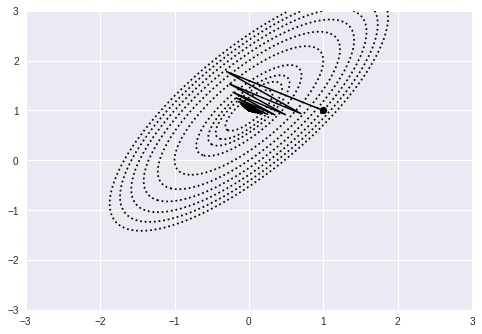

In [0]:
import matplotlib.pyplot as plt

alg = GradientDescent(f, df, alpha=0.13)
initial = np.array([1, 1])
alg.solve(initial)
print(alg.x_)
print(alg.opt_)

plt.scatter(initial[0], initial[1], color='k', marker='o')
plt.plot(alg.path_[:, 0], alg.path_[:, 1], color='k', linewidth=1.5)
xs = np.linspace(-3, 3, 200)
ys = np.linspace(-3, 3, 200)
xmesh, ymesh = np.meshgrid(xs, ys)
xx = np.r_[xmesh.reshape(1, -1), ymesh.reshape(1, -1)]
levels = [-3, -2.8, -2.6, -2.4, -2, -1, 0, 1, 2, 3, 4]

plt.contour(xs, ys, f(xx).reshape(xmesh.shape), levels=levels, colors='k', linestyles='dotted')
plt.show()

### 確率的勾配降下法(Stochastic Gradient Descent, SGD)
・NNのコスト関数は非凸かつplateauなものが多いので、単純な勾配降下法のようなやり方だと全体最適解に辿り着きにくい（局所解に陥りやすい）。

・そこで重みw更新の際に使用するデータをランダムにサンプリングしてやることで、局所解から抜け出せる確率を上げられないかという発想

1.   初期の重みを設定し、コスト関数E(θ)を設定する。
2.   データをランダムにサンプリングする。
3.   サンプルをもとに最も損失が少なくなる方向
$$
g = -\frac {\partial E(\theta)}{\partial w}
$$
に少し移動する。

4.   1~3を十分な回数繰り返す。


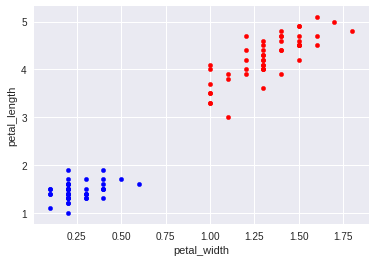

<Figure size 432x288 with 0 Axes>

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import pandas as pd
import seaborn as sns

from sklearn import datasets

iris = sns.load_dataset('iris')

data = iris[:100]
columns = ['petal_width', 'petal_length']
x = data[columns]
y = data['species']

y = (y == 'setosa').astype(int)

def plot_iris(x, y, colors, ax=None):
  if ax is None:
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
  plt.figure()
  x1 = x.columns[0]
  x2 = x.columns[1]
  
  for (species, group), c in zip(x.groupby(y), colors):
    group.plot(kind='scatter', x=x1, y=x2, color=c, ax=ax)
  
  return ax
    
plot_iris(x, y, colors=['red', 'blue'])
plt.show()


In [0]:
def sigmoid(x):
  return 1./(1. + np.exp(-x))

def calc_y(x, w ,b):
  y = np.dot(x, w) + b
  return sigmoid(y)

def calc_grad(x, y, w, b):
  error = y - calc_y(x, w, b)
  w_grad = -np.mean(x.T * error, axis = 1)
  b_grad = -np.mean(error)
  
  return w_grad, b_grad

In [0]:
nb_epochs = 50

#Gradient Descent
def GD(x, y, w, b, eta=1.0):
  for i in range(1, nb_epochs):
    w_grad, b_grad = calc_grad(x, y, w, b)
    w = w - eta * w_grad
    b = b- eta * b_grad
    e = np.mean(np.abs(y - calc_y(x, w, b)))
    yield i, w, b, e

In [0]:
#Stochastic Gradient Descent
def SGD(x, y, w, b, eta=1.0):
  for i in range(1, nb_epochs):
    indexer = np.arange(x.shape[0]) #num of data
    np.random.shuffle(indexer)
    for index in indexer[:10]:
      _x = x.iloc[[index], ]
      _y = y.iloc[[index], ]
      w_grad, b_grad = calc_grad(_x, _y, w, b)
      w -= eta*w_grad
      b -= eta*b_grad
      e = np.mean(np.abs(y - calc_y(x, w, b)))
      
      yield i, w, b, e

In [0]:
%matplotlib inline


def plot_result(x, y, solver, title):
  fig = plt.figure()
  
  ax = fig.add_subplot(1, 1, 1)
  plt.xlim([0.0, 2.0])
  plt.ylim([-1.0, 6.0])
  
  art_objs = []
  
  bx = np.arange(x.iloc[:, 0].min(), x.iloc[:, 0].max(), 0.1)
  
  w, b = np.zeros(2), 0
  gen = solver(x, y, w, b)
  
  for i, w, b, e in gen:
    by = -b / w[1] - w[0] / w[1] * bx
    
    l = ax.plot(bx, by, color='gray', linestyle='dashed', alpha=(i/nb_epochs)/2.+0.5)
    
    art_objs.append(l)
  
  ax = plot_iris(x, y, colors=['red', 'blue'], ax=ax)
  ax.set_title(title)
  plt.show()
  
  print(w)

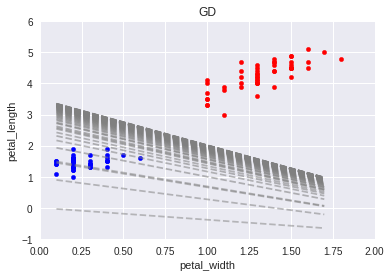

<Figure size 432x288 with 0 Axes>

petal_width    -1.705603
petal_length   -1.148750
dtype: float64


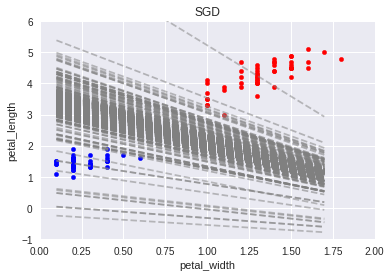

<Figure size 432x288 with 0 Axes>

petal_width    -3.758331
petal_length   -2.399118
dtype: float64


In [0]:
plot_result(x, y, GD, title='GD')
plot_result(x, y, SGD, title='SGD')